In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import mnist

import numpy as np
import sys, os
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline 

In [45]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Image 17936 in training dataset:
Label: 9


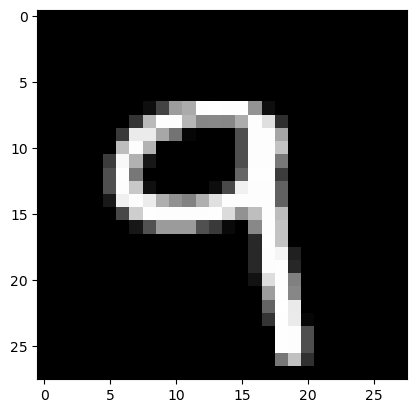

In [46]:
# Look at sample
ith = np.random.randint(X_train.shape[0])
print(f'Image {ith} in training dataset:')
print(f'Label: {y_train[ith]}')
plt.imshow(X_train[ith], cmap='gray')

In [47]:
# Flatten dataset
N, H, W = X_train.shape
D = H * W
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

# Scale dataset
X_train = X_train / 255.0 * 2 - 1
X_test = X_test / 255.0 * 2 - 1

In [48]:
latent_dim = 100

In [49]:
# Build Generator
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [50]:
# Build discriminator
def build_discriminator(img_size):
    i = Input(shape=(img_size, ))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [51]:
# Build discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build combined model
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
generator_output = generator(z)
discriminator.trainable = False
faked_pred = discriminator(generator_output)

combined_model = Model(z, faked_pred)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
)


In [52]:
# Training

# Configuration
batch_size = 32
epochs = 30000
sample_period = 1000 # Print result of model after each 200 epochs

directory = 'gan_images'

# Labels for training process in each batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Save of discriminator's and generator's losses
d_losses = []
g_losses = []

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f'Directory created: {directory}')
else:
    for file in glob(os.path.join(directory, '*.*')):
        os.remove(file)
    print(f'Directory {directory} is already existed')

Directory gan_images is already existed


In [53]:
def sample_images(epoch, parent_dir):
    rows, cols = 5, 5
    noise = np.random.randn(rows*cols, latent_dim)
    imgs = generator.predict(noise)

    fig, ax = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            ax[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            ax[i, j].axis('off')
            idx += 1
    path = os.path.join(parent_dir, f'{epoch}.png')
    fig.savefig(path)
    plt.close()

In [54]:
for epoch in range(epochs):
    # Train discriminator
    # Real Images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_images = generator.predict(noise)

    d_loss_real, d_accuracy_real = discriminator.train_on_batch(real_images, ones)
    d_loss_fake, d_accuracy_fake = discriminator.train_on_batch(fake_images, zeros)

    d_loss = (d_loss_fake + d_loss_real) / 2
    d_accuracy = (d_accuracy_real + d_accuracy_fake) / 2

    # Train generator
    g_loss = combined_model.train_on_batch(noise, ones)

    g_losses.append(g_loss)
    d_losses.append(d_loss)

    if epoch % 200 == 0:
        print(f'Epoch {epoch}: g_loss - {g_loss} | d_loss - {d_loss} | d_accuracy - {d_accuracy}')
    
    if epoch % sample_period == 0:
        sample_images(epoch, 'gan_images')
sample_images(30000, 'gan_images')
    

1/1 [==============================] - 0s 41ms/step
Epoch 0: g_loss - 0.7715095281600952 | d_loss - 0.8704439997673035 | d_accuracy - 0.453125
1/1 [==============================] - 0s 9ms/step
Epoch 200: g_loss - 3.4391469955444336 | d_loss - 0.48688648332060325 | d_accuracy - 0.8125
1/1 [==============================] - 0s 10ms/step
Epoch 400: g_loss - 1.4309885501861572 | d_loss - 0.6240032613277435 | d_accuracy - 0.640625
1/1 [==============================] - 0s 9ms/step
Epoch 600: g_loss - 0.7290322780609131 | d_loss - 0.6223688125610352 | d_accuracy - 0.59375
1/1 [==============================] - 0s 10ms/step
Epoch 800: g_loss - 0.7924336791038513 | d_loss - 0.6362006962299347 | d_accuracy - 0.671875
1/1 [==============================] - 0s 9ms/step
Epoch 1000: g_loss - 0.8589205741882324 | d_loss - 0.5960741639137268 | d_accuracy - 0.765625
1/1 [==============================] - 0s 10ms/step
Epoch 1200: g_loss - 0.9260398745536804 | d_loss - 0.5496135652065277 | d_accuracy -

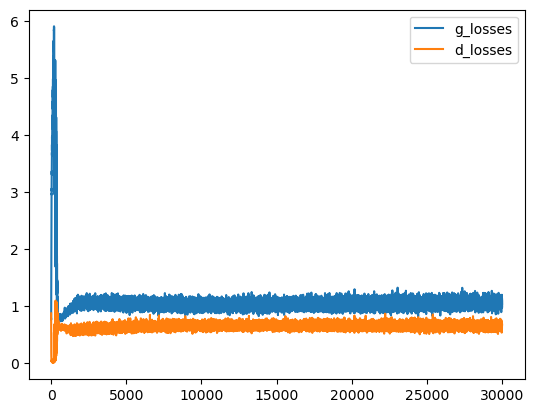

In [61]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

Epoch 0 -----------------------------------------
g_loss - 1.0371593236923218 | d_loss - 0.6715812683105469


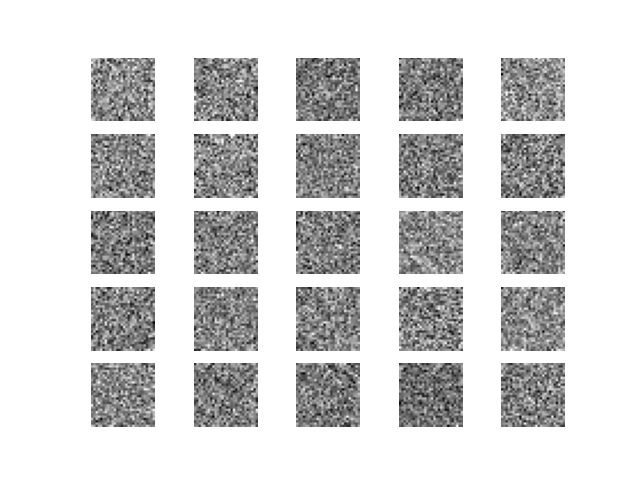

In [68]:
e = 0
print(f'Epoch {e} -----------------------------------------')
print(f'g_loss - {g_losses[e-1]} | d_loss - {d_losses[e-1]}')
img = image.load_img(os.path.join(directory, f'{e}.png'))
display(img)

Epoch 1000 -----------------------------------------
g_loss - 0.8840039372444153 | d_loss - 0.6086994111537933


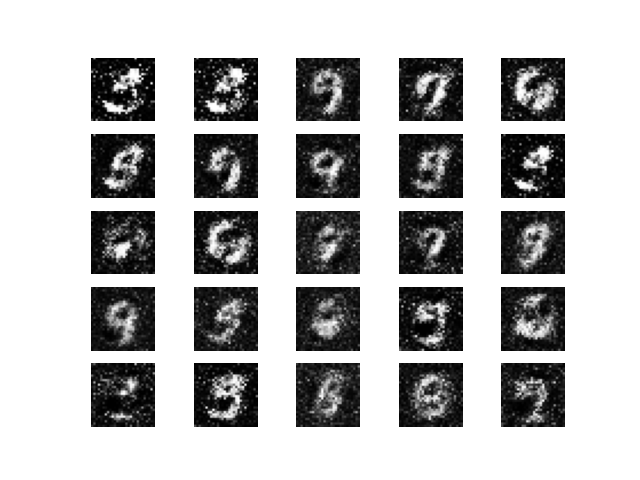

In [66]:
e = 1000
print(f'Epoch {e} -----------------------------------------')
print(f'g_loss - {g_losses[e-1]} | d_loss - {d_losses[e-1]}')
img = image.load_img(os.path.join(directory, f'{e}.png'))
display(img)

Epoch 5000 -----------------------------------------
g_loss - 0.9620283842086792 | d_loss - 0.6584171056747437


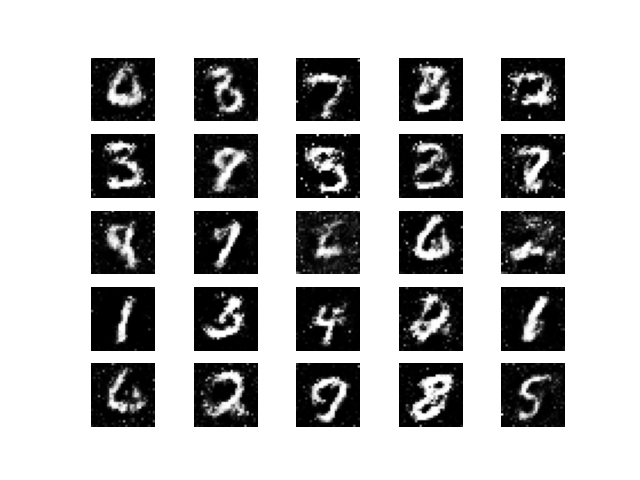

In [69]:
e = 5000
print(f'Epoch {e} -----------------------------------------')
print(f'g_loss - {g_losses[e-1]} | d_loss - {d_losses[e-1]}')
img = image.load_img(os.path.join(directory, f'{e}.png'))
display(img)

Epoch 15000 -----------------------------------------
g_loss - 1.1244354248046875 | d_loss - 0.5914453268051147


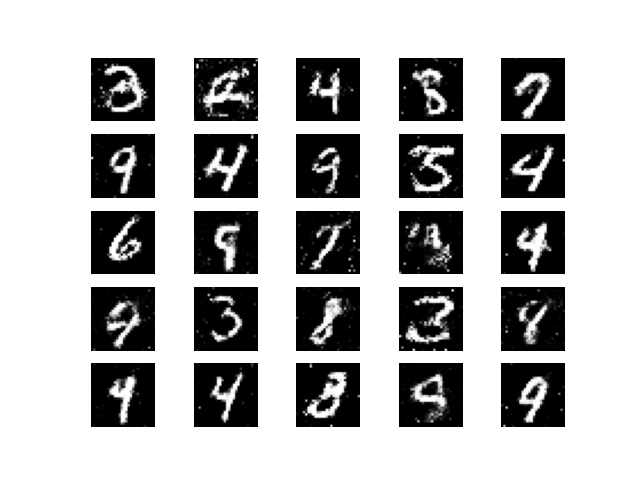

In [70]:
e = 15000
print(f'Epoch {e} -----------------------------------------')
print(f'g_loss - {g_losses[e-1]} | d_loss - {d_losses[e-1]}')
img = image.load_img(os.path.join(directory, f'{e}.png'))
display(img)

Epoch 30000 -----------------------------------------
g_loss - 1.0371593236923218 | d_loss - 0.6715812683105469


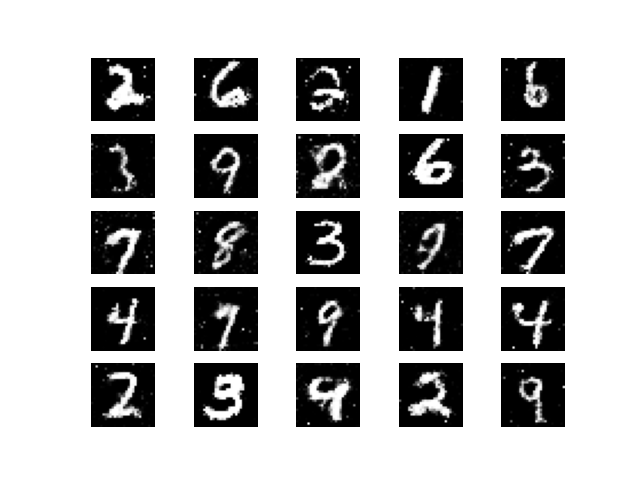

In [71]:
e = 30000
print(f'Epoch {e} -----------------------------------------')
print(f'g_loss - {g_losses[e-1]} | d_loss - {d_losses[e-1]}')
img = image.load_img(os.path.join(directory, f'{e}.png'))
display(img)